# NFL Punt Analytics Report

In an effort to crowdsource a solution for safer punt plays in professional (American) football games, the National Football League (NFL) has created a Kaggle competition seeking a data-backed proposal for punt-play rule changes. This follows a season where kickoff rules were changed to reduce injuries.

## Assumptions and Shortcomings

### Assumptions
This dataset is derived from the set of all punt plays in the 2016 and 2017 football seasons. Any conclusions drawn from analysis of this data assumes that punt plays and injury distribution during these two seasons are representative of all seasons (or at least seasons within the modern football era). The analysis in this report will be skewed if the number or logistics of injuries in other seasons varies significantly from the 2016 and 2017 seasons.

For ease of classifying weather into a manageable number of categories, I ignored temperatures and focused on weather that might impair game play quality such as precipitation, wind, and visibility. Some of the weather categories may have been over-generalized, but I do not believe this resulted in a gross mis-characterization in the role weather plays in causing punt injuries.

### Shortcomings
The data for injury plays contained only 38 records. This is small and could have contributed to bias in the statistical tests used to confirm or reject hypotheses. Specifically, the chi square test assumes at least 5 expected observations for each category, and I know that was not the case for some of the categories tested above. 

Most of the relevant data in these datasets were qualitative, string data. This made it difficult to quickly and easily use pandas and matplotlib to perform statistical analysis and visualization. Some of the data went from pandas column to dictionary to new column to dictionary with percentages. It was more convoluted than I had anticipated.

The hardware I was using to explore this data did not allow for me to thoroughly investigate the potential correlations between the positional and directional data in the Next Generation Statistics and injury plays.

## The Dataset

The dataset provided by the NFL for this competition is actually a robust set of smaller datasets collected from the 2016 and 2017 NFL seasons. There are CSV files for the following information: 

   - Game Data 
   - Play Info 
   - Player Punt Data (Each player's traditional position) 
   - Play Player Role Data (Player role during punt plays) 
   - Video Review (Detailed injury play data) 
   - Next Generation Statistics (Positional and temporal data for extrapolating player speed/acceleration)

The sum of these datasets is about 10 GB of data that can be concatenated on common columns such as Game Key, Play ID, and GSISID(PlayerID). Let's take a look at what they contain.

In [1]:
#Import the necessary libraries and modules
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, OrderedDict
from math import floor
from scipy.stats import ttest_ind, chisquare
%matplotlib inline

In [2]:
#Set a for loop to iterate over each data file
for path in glob.glob('*.csv'):
    
#Use a with statement to ensure files close upon completion. Set a count variable and a column header empty list.
    with open(path) as f:
        count = 0
        columns = []
        
#Set up a for loop to iterate over each row of the file. Append the first row to the column headers list and keep track of count.
        for row in f:
            if count == 0:
                columns.append(row)
            count += 1
            
    print('Dataset: {}'.format(path))
    print('Record Count: {}'.format(count))
    print('Column Headers: {}\n'.format(', '.join(columns)))

Dataset: game_data.csv
Record Count: 667
Column Headers: GameKey,Season_Year,Season_Type,Week,Game_Date,Game_Day,Game_Site,Start_Time,Home_Team,HomeTeamCode,Visit_Team,VisitTeamCode,Stadium,StadiumType,Turf,GameWeather,Temperature,OutdoorWeather


Dataset: NGS-2016-post.csv
Record Count: 963325
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


Dataset: NGS-2016-pre.csv
Record Count: 6824902
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


Dataset: NGS-2016-reg-wk1-6.csv
Record Count: 8706353
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


Dataset: NGS-2016-reg-wk13-17.csv
Record Count: 7611810
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


Dataset: NGS-2016-reg-wk7-12.csv
Record Count: 8382660
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


Dataset: NGS-2017-post.csv
Record Count: 1037159
Column Headers: Season_Year,GameKey,PlayID,GSISID,Time,x,

Salient characteristics of these files:

- The sample of injury-producing plays is small (38) compared to the sample of all punt plays in 2016/17 (6,682).
- The NGS files are too big to hold in memory as Pandas data frames
- Any merges performed with the video footage files will requires changing the column headers 'gamekey' and 'playid' to 'GameKey' and 'PlayID'.

Columns of interest toward finding correlation with injuries:

- Temperature
- GameWeather
- Turf
- Role
- Player_Activity_Derived
- Primary_Impact_Type
- Primary_Partner_Activity_Derived
- Score_Home_Visiting

Let's investigate the data quality.

In [3]:
#Import game data as a Pandas Data Frame
gamedata_df = pd.read_csv('game_data.csv')

#Check for NaN values
gamedata_df.isna().sum()

GameKey             0
Season_Year         0
Season_Type         0
Week                0
Game_Date           0
Game_Day            0
Game_Site           0
Start_Time          0
Home_Team           0
HomeTeamCode        0
Visit_Team          0
VisitTeamCode       0
Stadium             0
StadiumType        38
Turf                1
GameWeather        98
Temperature        66
OutdoorWeather    254
dtype: int64

In [4]:
#Check the types of the columns to determine how best to impute NaN values
gamedata_df.dtypes

GameKey             int64
Season_Year         int64
Season_Type        object
Week                int64
Game_Date          object
Game_Day           object
Game_Site          object
Start_Time         object
Home_Team          object
HomeTeamCode       object
Visit_Team         object
VisitTeamCode      object
Stadium            object
StadiumType        object
Turf               object
GameWeather        object
Temperature       float64
OutdoorWeather     object
dtype: object

## Dealing with Null Values

The three columns of interest in Game Data have null values. Since temperature is a float type, I would like to fill the null values with the series mean rounded to the floor integer. Before I do, I would like to know if any of the injury-producing plays is missing a temperature value, since that could contribute bias to the analysis. 

Turf and GameWeather are also missing values, however they are string objects and an Unknown value can be entered for any null values. This will not significantly impact the Turf analysis, but the GameWeather is missing around 15% of its values. 

In [5]:
#Create a Data Frame of just injury producing games for comparison with all games
injury_games_df = pd.merge(gamedata_df, pd.read_csv('video_review.csv'),
                           on=['GameKey', 'Season_Year'], how='inner')
injury_games_df.isna().sum()

GameKey                              0
Season_Year                          0
Season_Type                          0
Week                                 0
Game_Date                            0
Game_Day                             0
Game_Site                            0
Start_Time                           0
Home_Team                            0
HomeTeamCode                         0
Visit_Team                           0
VisitTeamCode                        0
Stadium                              0
StadiumType                          1
Turf                                 0
GameWeather                          3
Temperature                          0
OutdoorWeather                      14
PlayID                               0
GSISID                               0
Player_Activity_Derived              0
Turnover_Related                     0
Primary_Impact_Type                  0
Primary_Partner_GSISID               3
Primary_Partner_Activity_Derived     2
Friendly_Fire            

Here we see that null values in the Game Data columns of interest for injury-producing plays only exist in GameWeather (3 of 38). We can also see null values for the category of interest Primary_Partner_Activity_Derived (2 of 38). These null values can be safely filled with the string 'Unknown'.

In [6]:
#Replace temperature null values with the mean minus any decimal point precision
gamedata_df['Temperature'].fillna(floor(np.mean(gamedata_df['Temperature'])), inplace=True)

#Replace all null values in string columns with 'Unknown'
gamedata_df.fillna('Unknown', inplace=True)

In [7]:
#Check unique values for weather
gamedata_df.GameWeather.unique()

array(['Unknown', 'Sunny', 'Party Cloudy',
       'Partly Cloudy, Chance of Rain 80%', 'Partly Cloudy', 'T-Storms',
       'Cloudy', 'Mostly Cloudy', 'Hazy, hot and humid', 'Indoor',
       'Clear and warm', 'Controlled Climate', 'Suny',
       'Chance of Showers', 'Mostly Clear. Gusting ot 14.', 'Indoors',
       'Mostly cloudy',
       'Cloudy with Possible Stray Showers/Thundershowers',
       'Mostly CLoudy', 'Clear', 'Partly sunny', 'Rain', 'Mostly Sunny',
       'Sunny and Clear', 'Partly CLoudy',
       'Cloudy, Humid, Chance of Rain', 'Sunny Intervals', 'Fair',
       'Controlled', 'Sunny Skies', 'Partly Sunny', 'Sunny intervals',
       'Clear Skies', 'Clear and cool', 'Cloudy with rain',
       'Snow Showers, 3 to 5 inches expected.', 'Sunny and cool',
       'Snow showers', 'Snow', 'Partly cloudy', 'Cloudy, steady temps',
       'Cloudy, Rain', 'Cloudy and Cold', 'Cloudy with patches of fog',
       'Scattered thunderstorms', 'Sunny and warm', 'cloudy',
       'Light Rain', 

While much of the data was standardized, columns like GameWeather and Turf have far too many values and non-standard inputs for similar values. I will go through the process of reducing the number of values to something more manageable for visualization.

In [8]:
#Standardize and reduce the number of weather values
nw = {}
for value in gamedata_df.GameWeather.unique():
    s = str(value).lower()
    if 'snow' in s:
        nw[value] = 'snow'
    elif 'rain' in s or 'shower' in s and 'chance' not in s and 'possible' not in s:
        nw[value] = 'rain'
    elif 'cold' in s:
        nw[value] = 'cold'
    elif 'wind' in s or 'gust' in s:
        nw[value] = 'windy'
    elif 'sun' in s or 'clear' in s:
        nw[value] = 'pleasant'
    elif 'storm' in s:
        nw[value] = 'stormy'
    elif 'hot' in s:
        nw[value] = 'hot'
    elif 'fog' in s or 'haz' in s:
        nw[value] = 'reduced visibility'
    elif 'indoor' in s or 'control' in s:
        nw[value] ='indoor'
    elif 'unknown' in s:
        continue
    else:
        nw[value] = 'cloudy/mixed'
        
gamedata_df['GameWeather'].replace(nw.keys(), nw.values(), inplace=True)

In [9]:
#Standardize and reduce number of turf values
nw = {}
for value in gamedata_df.Turf.unique():
    t = str(value).lower()
    if 'grass' in t or 'nat' in t:
        nw[value] = 'grass'
    elif 'turf' in t:
        nw[value] = 'turf'
    elif 'art' in t or 'syn' in t:
       nw[value] = 'artificial'
    elif 'ubu' in t:
        nw[value] = 'ubu_speed'
    else:
        nw[value] = 'other'
        
gamedata_df['Turf'].replace(nw.keys(), nw.values(), inplace=True)

## Visualizing the Data

Now that the data has been standardized, we can visualize the data and some statistics for the one column that contains numerical data. First, though, I am going to assign a number to each string value so it is easier to plot. Then I need to merge the video_review file again with the updated game data frame to make comparisons. 

In [10]:
def num_category(df, col, name):
    ''' Assign a number based on unique string values within a column to use for histogram, create a dictionary to use 
    to label those numbers on the histogram x-axis.
    :param df: data frame, dataframe to operate on
    :param col: str, existing dataframe column to categorize
    :param name: str, name for new column with numerical categories'''
    unq = np.unique(df[col]) 
    df[name] = [list(unq).index(v) for v in df[col]]
    key_dict = {k:v for k, v in enumerate(unq)}
    return df, key_dict

In [11]:
#Add numerical category columns for GameWeather and Turf
gamedata_df, weather_dict = num_category(gamedata_df, 'GameWeather', 'weather')
gamedata_df, turf_dict = num_category(gamedata_df, 'Turf', 'turf')

In [12]:
#Merge the video review of injuries with updated game data df and fill NaNs in video_review
injury_games_df = pd.merge(gamedata_df, pd.read_csv('video_review.csv'),
                           on=['GameKey', 'Season_Year'], how='inner')
injury_games_df.fillna('Unknown', inplace=True)

In [13]:
def compare_hists(x1, x2, label1=None, label2=None, title1=None, title2=None, figsize=(10, 5)):
    '''Create a plot with subplots of histograms for comparison
    :param x: series or array-like, data to be plotted
    :param label: series or list, labels for the data
    :param title: string, values to fill in plot titles
    :param figsize: tuple, length and height of plot'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    
    ax1.hist(x1)
    
    #If a label argument is passed, set the xtick labels vertically
    if label1:
        ax1.set_xticks(range(len(label1)))
        ax1.set_xticklabels(label1, rotation='vertical')
    
    #If the data is not string type, set x limits
    if x1.dtype != 'object':
        x_min, x_max = min(x1), max(x1)
        ax1.set_xlim(x_min, x_max)
        
    ax1.set_title('2016/17 Punts by {}'.format(title1))
    
    ax2.hist(x2, color='r')
    
    #If a label argument is passed, set the xtick labels vertically
    if label2:
        ax2.set_xticks(range(len(label2)))
        ax2.set_xticklabels(label2, rotation='vertical')
        
    #If the data is not string type, set x limits
    if x2.dtype != 'object':
        ax2.set_xlim(x_min,  x_max)
        
    ax2.set_title('2016/17 Punts by {}'.format(title2))
    
    return plt.show()
    

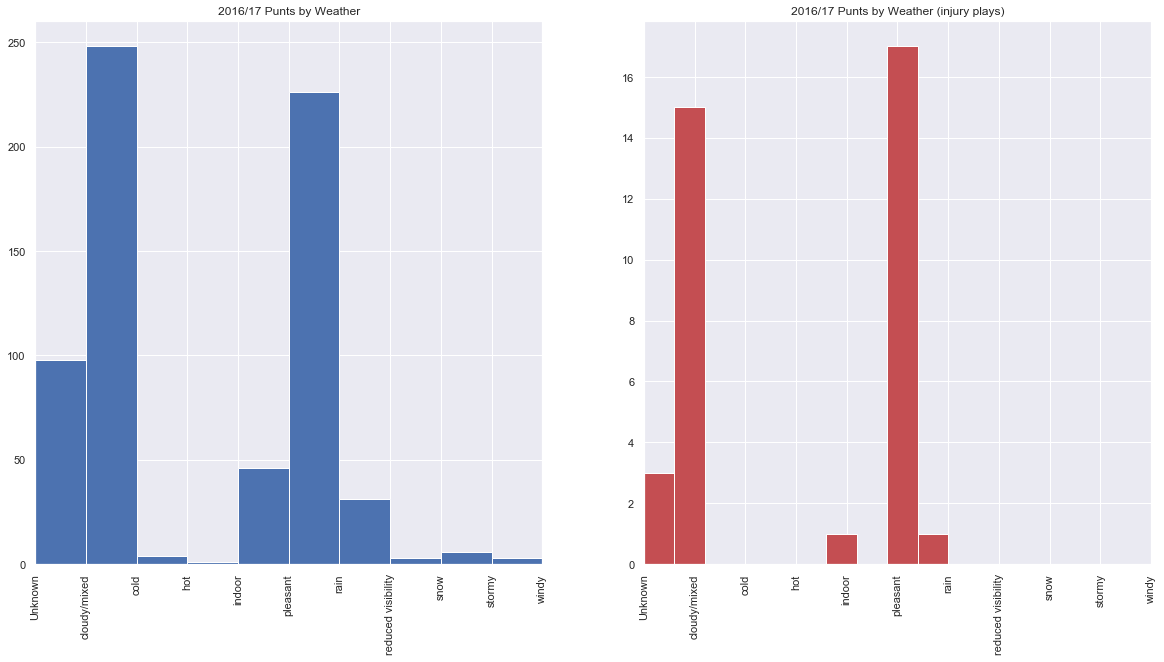

In [14]:
#Set the style with the Seaborn default and call a function to generate histograms comparing the distributions
#of all game weather and the weather during games producing injuries
sns.set()
compare_hists(gamedata_df['weather'], injury_games_df['weather'], label1=weather_dict.values(),
              label2=weather_dict.values(), title1='Weather', title2='Weather (injury plays)',
             figsize=(20, 10))

On the left in blue, we see the distribution of all games by Game Weather. On the right, in red is the distribution of injury producing games by Game Weather. The distributions appear to be similar with a slight surplus of injuries in pleasant weather games.

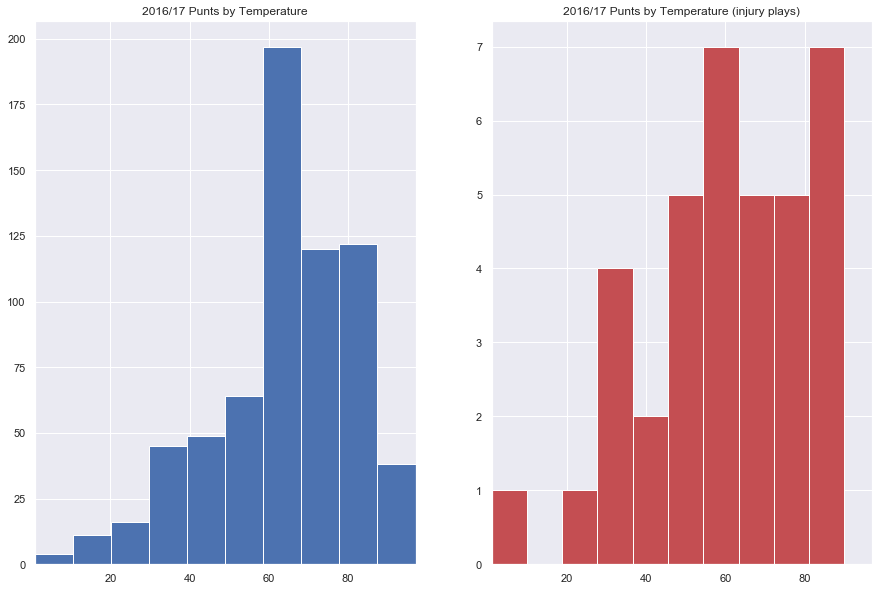

Temperature Mean(total): 64.11861861861861  Standard Deviation: 17.605351234376982

Temperature Mean(injury): 60.729729729729726  Standard Deviation: 21.001478260259283


In [15]:
#Call a function to generate histograms comparing the distributions of all game temperature and the temperature 
#during games producing injuries. Check the mean and standard deviation of both sets of data
compare_hists(gamedata_df['Temperature'], injury_games_df['Temperature'],
              title1='Temperature', title2='Temperature (injury plays)',
             figsize=(15, 10))

print('Temperature Mean(total): {}  Standard Deviation: {}\n'.format(np.mean(gamedata_df['Temperature']), np.std(gamedata_df['Temperature'])))
print('Temperature Mean(injury): {}  Standard Deviation: {}'.format(np.mean(injury_games_df['Temperature']), np.std(injury_games_df['Temperature'])))

The injury distribution by temperature appears right-biased compared to the distribution of all games. This is worth exploring with statistical tests for correlation.

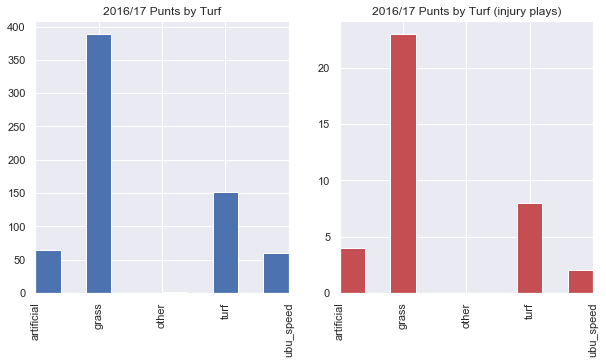

In [16]:
#Call a function to generate histograms comparing the distributions of all turf types and those during games producing injuries
compare_hists(gamedata_df['turf'], injury_games_df['turf'], label1=turf_dict.values(), 
              label2=turf_dict.values(), title1='Turf', title2='Turf (injury plays)')

Looking at the distributions based on the type of turf the games were played on, the injury-producing games almost perfectly match the distribution of all games.

## Question 1: Do environmental variables (weather, temperature, turf) play a significant factor in punt injuries?

Having looked at the visual representations of these variables for the set of all plays and the subset of injury-producing plays, the distributions appeared to match up. Still, it is worth looking at some statistical tests for a more precise likelihood of correlation.

In [17]:
#Perform T-Tests to determine the likelihood that the samples are representative of the same population
print('Temperature T-Test: {}'.format(ttest_ind(injury_games_df['Temperature'], gamedata_df['Temperature'], equal_var=False)))

Temperature T-Test: Ttest_indResult(statistic=-0.9502789757067102, pvalue=0.347854407196727)


This T-Test confirms the null hypothesis, that temperature does not have a significant impact on injuries, since a p-value of 0.35 is well above the commonly used alpha 0.05. 
### Conclusion: Temperature has no demonstrably signifcant correlation to injury.

In [18]:
def get_percentages(data):
    '''Take a frequency count from array-like data and create a sorted, ordered dictionary of percentages
    :param data: Pandas Series or array-like, the data from which to count frequency'''
    l = len(data)
    ddict = dict(Counter(list(data)))
    ddict.update((k, v/l) for k, v in ddict.items())
    ddict = OrderedDict(sorted(ddict.items()))
    return ddict

In [19]:
#Create a dictionary with frequency counts for weather during injury-producing games
injured_weather = dict(Counter(list(injury_games_df['weather'])))

#Create a dictionary with percent distributions of weather over all games and multiply by number injury games
game_weather = get_percentages(gamedata_df['weather'])
game_weather.update((k, v*38) for k, v in game_weather.items())

#Give 0 values for all weather types not found in injury-producing games
for key in game_weather.keys():
    if key not in injured_weather.keys():
        injured_weather[key] = 0
injured_weather = OrderedDict(sorted(injured_weather.items()))

#Use Chi Square Test to accept or reject null hypothesis
print('Weather Chi-Square Test: {}'.format(chisquare(list(injured_weather.values()), list(game_weather.values()))))

Weather Chi-Square Test: Power_divergenceResult(statistic=4.868793035994966, pvalue=0.8997685525718967)


This Chi-Square Test confirms the null hypothesis, that weather does not have significant correlation with injury, because of the large p-value.
### Conclusion: Weather has no demonstrably significant correlation to injury.

In [20]:
#Create a dictionary with frequency counts for turf during injury-producing games
injured_turf = dict(Counter(list(injury_games_df['turf'])))

#Create a dictionary with percent distributions of turf type over all games and multiply by number injury games
game_turf = get_percentages(gamedata_df['turf'])
game_turf.update((k, v*38) for k, v in game_turf.items())

#Give 0 values for all turf types not found in injury-producing games
for key in game_turf.keys():
    if key not in injured_turf.keys():
        injured_turf[key] = 0
injured_turf = OrderedDict(sorted(injured_turf.items()))

#Use Chi Square Test to accept or reject null hypothesis
print('Turf Chi-Square Test: {}'.format(chisquare(list(injured_turf.values()), list(game_turf.values()))))

Turf Chi-Square Test: Power_divergenceResult(statistic=0.7449506300878249, pvalue=0.9456720821759017)


This Chi-Square Test confirms the null hypothesis, that turf type does not have significant correlation with injury, because of the large p-value.
### Conclusion: Turf has no demonstrably significant correlation to injury.

## Question 2: Do injuries occur more often to players who fill certain roles?

To answer this question, I want to see if the distribution of roles filled by players who get injured is significantly different from the total distribution of roles in punt plays all punt plays.

In [21]:
#Import player role data by punt play into a Pandas Data Frame
player_role_df = pd.read_csv('play_player_role_data.csv')

#Create a column for groups of roles that are similar to reduce number of unique values
#Standardize and reduce the number of weather values
nw = {}
for value in player_role_df.Role.unique():
    s = str(value).lower()
    if 'v' in s:
        nw[value] = 'Return Jammers'
    elif s == 'plt' or s == 'plg' or s == 'pls' or s=='prg' or s=='prt':
        nw[value] = 'Punt Line'
    elif 'g' in s:
        nw[value] = 'Punt Gunners'
    elif s == 'p':
        nw[value] = 'Punter'
    elif 'w' in s or 'c' in s or 'pp' in s:
        nw[value] = 'Punt Backfield'
    elif 'pd' in s:
        nw[value] = 'Return Line'
    elif 'fb' in s  or s ==  'pr':
        nw[value] = 'Returners'
    else:
        nw[value] = 'Return LBs'
        
player_role_df['Group'] = player_role_df['Role'].replace(nw.keys(), nw.values(), inplace=False)
#Create a Data Frame of just the players getting injured
injured_role_df = pd.merge(player_role_df, pd.read_csv('video_review.csv'), how='inner', on=['Season_Year', 'GameKey', 'PlayID', 'GSISID'])

#Check for NaNs 
player_role_df.isna().sum()

Season_Year    0
GameKey        0
PlayID         0
GSISID         0
Role           0
Group          0
dtype: int64

In [22]:
#Create a dictionary for percentage of total for each role group
group_dict = get_percentages(player_role_df['Group'])

#Create a dictionary for the percentage of injured role group
injured_group_dict = get_percentages(injured_role_df['Group'])

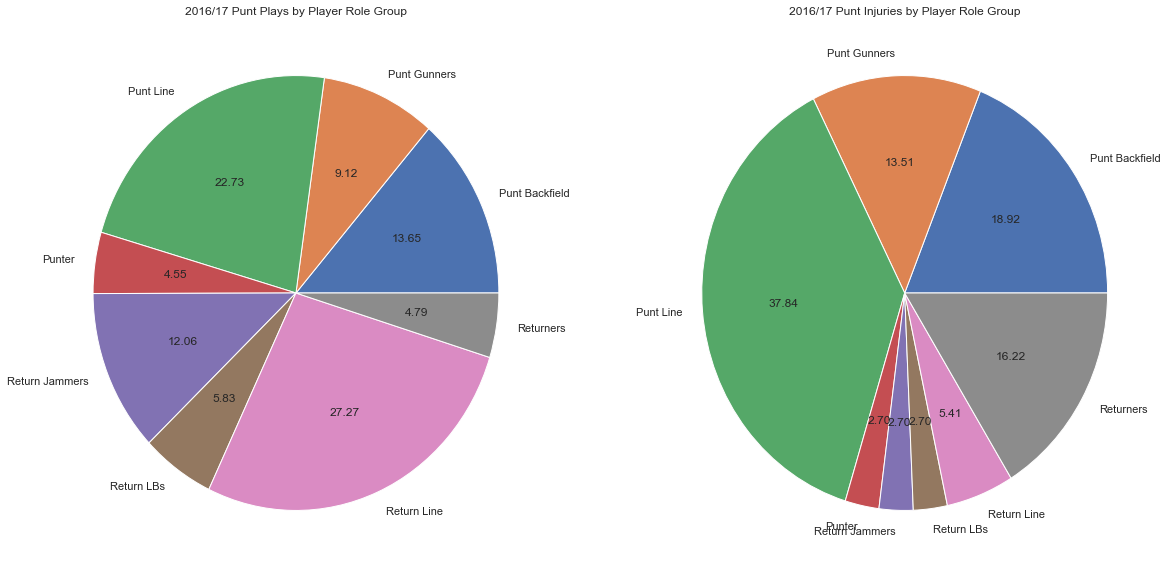

In [23]:
#Create pie charts comparing the distribution of all groups and the distribution of injured groups
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.pie(group_dict.values(), labels=group_dict.keys(), autopct='%0.2f')
plt.title('2016/17 Punt Plays by Player Role Group')

plt.subplot(1, 2, 2)
plt.pie(injured_group_dict.values(), labels=injured_group_dict.keys(), autopct='%0.2f') 
plt.title('2016/17 Punt Injuries by Player Role Group')
plt.show()

In [24]:
#Update the percent distributions with their frequency count over 38 injury-producing games
group_dict.update((k, v*38) for k, v in group_dict.items())
injured_group_dict.update((k, v*38) for k, v in injured_group_dict.items())

#Use Chi Square Test to accept or reject null hypothesis
print('Role Group Chi-Square Test: {}'.format(chisquare(list(injured_group_dict.values()), list(group_dict.values()))))

Role Group Chi-Square Test: Power_divergenceResult(statistic=26.09428768608364, pvalue=0.0004844980425985544)


This Chi Square test supports the alternate hypothesis, that there is a significant correlation between role group and injury.
### Conclusion: The following role groups are more susceptible to injury.

### Punt Line and Punt Backfield
Until the ball is punted, these players are trying to prevent the return line and LBs from reaching the ball or the punter. Once the ball is punted, their job becomes pursuing or containing and tackling the returner with the ball. The increase in injury proportion over representation is high for the punt line (37.8% over 22.7%) but not as bad for the punt backfield (19% over 13%). I did not expect these positions to represent over half of the injuries in this dataset.

### Returners
Returners are the players trying to advance the ball down the field following a punt. They represent a historically vulnerable position as they must wait for the ball to descend with their eyes skyward while gunners descend upon them at high speeds. Fair catch rules were implemented to allow for some protection from injury if the returner waves off the oncoming gunners and waives his right to advance the ball. Still we can see that returners are injured at a proportion 4 times greater than their representation in punt plays (16% of injuries vs 4-5% representation in punt plays).

### Gunners
Gunners are the players on the punt team that sprint down the field to intercept the returner or down the ball as far back as possible. Their two main functions are to hold the return team to minimal forward progress and try to turn the ball back over to their side. I expected them to garner a higher share of the injuries since they are a speed position, but it appears their injury proportion is only slightly higher than their representation.


## Question 3: Do Impact Type and Activity Play a Role in Injuries?

In the last section, we saw which role groups experience disproportionately high rates of injury. Are these injuries the result of the impact types and activities we would expect given the role group of these players, or is the activity or impact type randomly or counterintuitively distributed among these role groups. Since we do not have impact type and activity information for the set of all players in all punt plays, we cannot compare injuries to the proportion of the whole population. Using what we know about the functions these roles perform, however, we can make hypotheses about which impacts and activities we will find most often. 

### Gunners and Returners
These are the speed positions. I expect **_Gunners_** to be injured while **_tackling_** and **_Returners_** to be injured while being **_tackled_**. **_Helmet-to-helmet_** impacts are most likely to cause injuries based on my experience playing and watching football. This is especially true at high speeds.

### Punt Line and Punt Backfield
Based on their roles, I expect these postions to be injured while being **_blocked_**. In their first function as blockers, there is not as much space to pick up speed. Once the play heads downfield, more speed in open space leads to more impactful collisions. Again, I am expecting to see **_helmet-to-helmet_** impacts as the primary cause of injury.

In [25]:
x_len = range(len(injured_role_df['Group'].unique()))

In [26]:
#Show frequency counts of impact type by role group
impact = injured_role_df.groupby(['Group', 'Primary_Impact_Type']).size()
impact

Group           Primary_Impact_Type
Punt Backfield  Helmet-to-body         3
                Helmet-to-ground       1
                Helmet-to-helmet       2
                Unclear                1
Punt Gunners    Helmet-to-body         1
                Helmet-to-helmet       4
Punt Line       Helmet-to-body         8
                Helmet-to-ground       1
                Helmet-to-helmet       5
Punter          Helmet-to-helmet       1
Return Jammers  Helmet-to-body         1
Return LBs      Helmet-to-helmet       1
Return Line     Helmet-to-body         1
                Helmet-to-helmet       1
Returners       Helmet-to-body         3
                Helmet-to-helmet       3
dtype: int64

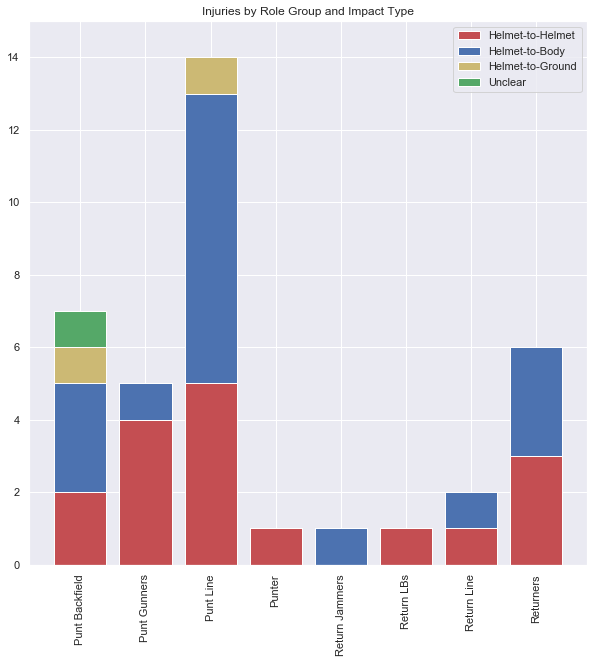

In [27]:
#Create arrays with the frequency counts for each impact type by role group
hh = np.array([2, 4, 5, 1, 0, 1, 1, 3])
hb = np.array([3, 1, 8, 0, 1, 0, 1, 3])
hg = np.array([1, 0, 1, 0, 0, 0, 0, 0])
un = np.array([1, 0, 0, 0, 0, 0, 0, 0])

#Create stacked bar charts showing the impact types and activity by player role group
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(x_len, height=hh, color='r')
ax.bar(x_len, height=hb, color='b', bottom=hh)
ax.bar(x_len, height=hg, color='y', bottom=hh+hb)
ax.bar(x_len, height=un, color='g', bottom=hh+hb+hg)

ax.set_title('Injuries by Role Group and Impact Type')
ax.set_ylim((0, 15))
ax.set_xticklabels(('', 'Punt Backfield', 'Punt Gunners', 'Punt Line', 'Punter', 'Return Jammers',
                    'Return LBs', 'Return Line', 'Returners'), rotation='vertical')
ax.legend(labels=('Helmet-to-Helmet', 'Helmet-to-Body', 'Helmet-to-Ground', 'Unclear'))

plt.show()

### Conclusion: Helmet-to-Helmet and Helmet-to-Body equally likely to injure any role group

Regardless of position, every injury was about equally likely to be caused by a helmet-to-helmet impact or a helmet-to-body impact. Helmet-to-ground was less likely to cause injury and only one impact type was unclear.

In [28]:
#Show frequency counts of activity type by role group
activity = injured_role_df.groupby(['Group', 'Player_Activity_Derived']).size()
activity

Group           Player_Activity_Derived
Punt Backfield  Blocked                    1
                Blocking                   3
                Tackling                   3
Punt Gunners    Blocked                    2
                Tackling                   3
Punt Line       Blocked                    7
                Tackling                   7
Punter          Tackled                    1
Return Jammers  Blocking                   1
Return LBs      Blocking                   1
Return Line     Blocking                   2
Returners       Blocking                   1
                Tackled                    5
dtype: int64

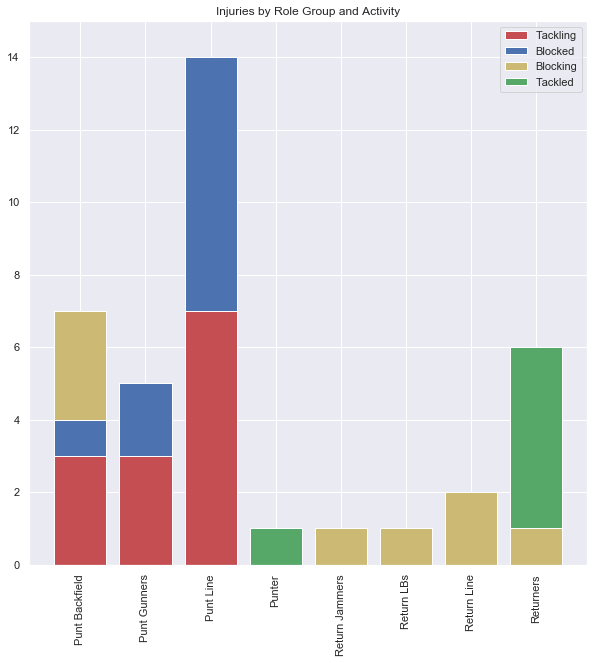

In [29]:
#Create arrays with the frequency counts for each activity by role group
tg = np.array([3, 3, 7, 0, 0, 0, 0, 0])
bd = np.array([1, 2, 7, 0, 0, 0, 0, 0])
bg = np.array([3, 0, 0, 0, 1, 1, 2, 1])
td = np.array([0, 0, 0, 1, 0, 0, 0, 5])

#Create stacked bar charts showing the impact types and activity by player role group
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(x_len, height=tg, color='r')
ax.bar(x_len, height=bd, color='b', bottom=tg)
ax.bar(x_len, height=bg, color='y', bottom=tg+bd)
ax.bar(x_len, height=td, color='g', bottom=tg+bd+bg)

ax.set_title('Injuries by Role Group and Activity')
ax.set_ylim((0, 15))
ax.set_xticklabels(('', 'Punt Backfield', 'Punt Gunners', 'Punt Line', 'Punter', 'Return Jammers',
                    'Return LBs', 'Return Line', 'Returners'), rotation='vertical')
ax.legend(labels=('Tackling', 'Blocked', 'Blocking', 'Tackled'))

plt.show()

### - Punt Line and Gunners about as likely to be injured being blocked as tackling. 
### - Returners mostly getting injured while being tackled
### - Punt Backfield equally likely to be injured tackling or blocking

I overestimated how much being blocked would contribute to injuries among the Punt Line and Punt Backfield and did not consider how much being blocked would contribute to injuries for Gunners.

## Future Research

I would also be interested in researching the records of the teams during injury plays to see if playoff hopes play a factor. On an individual level, if I could find a way to extrapolate the player name from position, team, and GSISID, I would like to explore whether age plays a factor as well, though I would need to control for the ages of all players by position in punt plays.

After learning more about supervised and unsupervised learning methods, I would like to dive back into the NGS data to search for correlation between the relative positions, velocities, and directions of players over time in the punt plays that cause injuries. Perhaps machine learning or feature importances on random forests can highlight some configurations that lead to punt plays. Finding these configurations would be the first step in devising rules to help avoid punt injuries. Unfortunately, I don't think I will have anything viable to submit by the competition deadline!
